# DATASET PREP

In [15]:
import numpy as np
np.complex = complex 
import torch
import librosa
import soundfile as sf
import musdb
from UNET.model import UNetVocalSeparator
import os
import soundfile as sf
import musdb
from IPython.display import Audio, display

**THIS BELOW CELL CREATES THE DATASET FOR THE MODEL TO RUN ON**

In [16]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNetVocalSeparator(base_channels=32).to(DEVICE)
model.load_state_dict(torch.load('UNET/unet_vocal_epoch200.pt', map_location=DEVICE))
model.eval()

sr_unet = 8192                    
sr_full = 44100                
n_fft = 1024
hop = 768
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_channels = 32           
pad_multiple = 16 

save_path = "vae_prepped"
os.makedirs(save_path, exist_ok=True)

In [18]:
# Load Tracks
tracks = musdb.DB(root='UNET/musdb18', subsets='train').tracks

pad_multiple_unet = 64 
pad_multiple_vae = 16

for track in tracks:
    print(f"Processing: {track.name}")

    #  Mono mixture and vocals
    mix = track.audio.mean(axis=1)
    gt_vocals = track.targets['vocals'].audio.mean(axis=1)

    # Resample to 8192 Hz
    mix_rs = librosa.resample(mix, orig_sr=track.rate, target_sr=sr_unet)
    gt_rs  = librosa.resample(gt_vocals, orig_sr=track.rate, target_sr=sr_unet)

    # STFT and magnitude/phase
    S_mix = librosa.stft(mix_rs, n_fft=n_fft, hop_length=hop)
    mag_mix, phase_mix = np.abs(S_mix), np.angle(S_mix)
    mag_mix = mag_mix[:512, :]
    phase_mix = phase_mix[:512, :]

    #  Normalize and pad to 64 frames (for UNet input)
    scale = mag_mix.max() if mag_mix.max() > 0 else 1.0
    mag_norm = mag_mix / scale

    T = mag_norm.shape[1]
    pad = (pad_multiple_unet - (T % pad_multiple_unet)) % pad_multiple_unet

    mag_padded = np.pad(mag_norm, ((0, 0), (0, pad)), mode='constant')
    phase_padded = np.pad(phase_mix, ((0, 0), (0, pad)), mode='constant')
    mag_input = mag_padded[None, None]  # [1,1,512,T]

    #  Inference
    with torch.no_grad():
        mask = model(torch.from_numpy(mag_input).float().to(DEVICE))
    mask = mask.cpu().numpy()[0, 0, :, :T]  # Unpad output to match original T

    # Masked magnitude
    vocal_mag = mask * mag_mix

    # Reconstruct waveform
    full_spec = np.pad(vocal_mag * np.exp(1j * phase_mix),
                       ((0, n_fft//2 + 1 - 512), (0, 0)), mode='constant')
    pred_audio = librosa.istft(full_spec, hop_length=hop, win_length=n_fft)

    #  Resample both prediction and GT to 44.1kHz
    pred_44 = librosa.resample(pred_audio, orig_sr=sr_unet, target_sr=sr_full)
    gt_44   = librosa.resample(gt_rs, orig_sr=sr_unet, target_sr=sr_full)

    #  Final STFTs for VAE input
    S_pred = librosa.stft(pred_44, n_fft=n_fft, hop_length=hop)
    S_gt   = librosa.stft(gt_44,   n_fft=n_fft, hop_length=hop)

    mag_pred, phase_pred = np.abs(S_pred), np.angle(S_pred)
    mag_gt, phase_gt     = np.abs(S_gt), np.angle(S_gt)

    # Pad to multiple of 16 frames (for VAE input)
    T_final = mag_pred.shape[1]
    pad_final = (pad_multiple_vae - (T_final % pad_multiple_vae)) % pad_multiple_vae

    mag_pred = np.pad(mag_pred, ((0, 0), (0, pad_final)), mode='constant')
    mag_gt   = np.pad(mag_gt,   ((0, 0), (0, pad_final)), mode='constant')
    phase_pred = np.pad(phase_pred, ((0, 0), (0, pad_final)), mode='constant')
    phase_gt   = np.pad(phase_gt,   ((0, 0), (0, pad_final)), mode='constant')

    #  Save
    out_path = f"{save_path}/{track.name}_vae.npz"
    np.savez_compressed(
        out_path,
        input=mag_pred.astype(np.float32),
        target=mag_gt.astype(np.float32),
        phase=phase_pred.astype(np.float32),
        phase_gt=phase_gt.astype(np.float32),
        scale=np.float32(scale)
    )

    print(f"Saved: {out_path}")

Processing: A Classic Education - NightOwl
Saved: vae_prepped/A Classic Education - NightOwl_vae.npz
Processing: ANiMAL - Clinic A
Saved: vae_prepped/ANiMAL - Clinic A_vae.npz
Processing: ANiMAL - Easy Tiger
Saved: vae_prepped/ANiMAL - Easy Tiger_vae.npz
Processing: ANiMAL - Rockshow
Saved: vae_prepped/ANiMAL - Rockshow_vae.npz
Processing: Actions - Devil's Words
Saved: vae_prepped/Actions - Devil's Words_vae.npz
Processing: Actions - One Minute Smile
Saved: vae_prepped/Actions - One Minute Smile_vae.npz
Processing: Actions - South Of The Water
Saved: vae_prepped/Actions - South Of The Water_vae.npz
Processing: Aimee Norwich - Child
Saved: vae_prepped/Aimee Norwich - Child_vae.npz
Processing: Alexander Ross - Goodbye Bolero
Saved: vae_prepped/Alexander Ross - Goodbye Bolero_vae.npz
Processing: Alexander Ross - Velvet Curtain
Saved: vae_prepped/Alexander Ross - Velvet Curtain_vae.npz
Processing: Angela Thomas Wade - Milk Cow Blues
Saved: vae_prepped/Angela Thomas Wade - Milk Cow Blues_v

# TRAINING

In [2]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim
from RESU.model import SpectrogramEnhancer 
from torch.optim.lr_scheduler import ReduceLROnPlateau


target_width = 4096
batch_size = 8
EPOCHS = 300
lambda_recon = 600
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
val_split = 0.2
learning_rate = 1e-4


In [3]:
class SpectrogramLogDataset(Dataset):
    def __init__(self, data_dir, target_width=1024):
        files = sorted(f for f in os.listdir(data_dir) if f.endswith(".npz"))
        self.data = []
        for f in files:
            arr = np.load(os.path.join(data_dir, f))
            self.data.append((arr["input"], arr["target"], arr["scale"]))
        self.target_width = target_width

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_mag, target_mag, scale = self.data[idx]
        input_mag  = input_mag[:512, :] * scale
        target_mag = target_mag[:512, :] * scale
        input_log  = np.log1p(input_mag)
        target_log = np.log1p(target_mag)

        def pad_crop(spec):
            T = self.target_width
            if spec.shape[1] >= T:
                return spec[:, :T]
            else:
                pad_width = T - spec.shape[1]
                return np.pad(spec, ((0,0),(0,pad_width)), mode="constant")

        x = torch.tensor(pad_crop(input_log)).unsqueeze(0).float()
        y = torch.tensor(pad_crop(target_log)).unsqueeze(0).float()
        return x, y

In [4]:
import torch.nn as nn

class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(16),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.layers(x)


In [ ]:
def center_crop_to_match(pred, target):
    _,_,Hp,Wp = pred.shape
    _,_,Ht,Wt = target.shape
    H = min(Hp, Ht);  W = min(Wp, Wt)
    return pred[:, :, :H, :W], target[:, :, :H, :W]

def ae_loss(pred, target):
    p, t = center_crop_to_match(pred, target)
    return F.l1_loss(p, t)

def perceptual_spectrogram_loss(pred, target):
    p, t = center_crop_to_match(pred, target)
    return F.l1_loss(p, t) + 0.1 * F.mse_loss(p, t)

dataset   = SpectrogramLogDataset("vae_prepped", target_width)
val_size  = int(len(dataset) * val_split)
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

# If your system gives you an error, set your workers to 0
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


G = SpectrogramEnhancer().to(device)
G.apply(lambda m: nn.init.kaiming_normal_(m.weight) 
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)) else None)

feature_extractor = FeatureExtractor().to(device)
feature_extractor.eval()
for param in feature_extractor.parameters():
    param.requires_grad = False 

def perceptual_feature_loss(pred, target, feature_extractor):
    p, t = center_crop_to_match(pred, target)
    features_p = feature_extractor(p)
    features_t = feature_extractor(t)
    return F.l1_loss(features_p, features_t)


optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

In [5]:
train_losses, val_losses = [], []

for epoch in range(1, EPOCHS + 1):
    # Training
    G.train()
    total_train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        pred = G(x)
        recon_loss = ae_loss(pred, y) + perceptual_spectrogram_loss(pred, y)
        feat_loss = perceptual_feature_loss(pred, y, feature_extractor)
        loss = lambda_recon * recon_loss + 0.5 * feat_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    train_losses.append(total_train_loss)

    # Validation
    G.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = G(x)
            recon_loss = ae_loss(pred, y) + perceptual_spectrogram_loss(pred, y)
            feat_loss = perceptual_feature_loss(pred, y, feature_extractor)

            loss = lambda_recon * recon_loss + 0.5 * feat_loss

            total_val_loss += loss.item()


    val_losses.append(total_val_loss)

    scheduler.step(total_val_loss) 

    # Logging
    print(f"Epoch {epoch:03d} | Train Loss: {total_train_loss:.2f} | Val Loss: {total_val_loss:.2f}")

    # Checkpoint
    if epoch % 50 == 0 or epoch == EPOCHS:
        torch.save(G.state_dict(), f"RESU/enhancer_epoch{epoch}.pth")


Epoch 001 | Train Loss: 8071.40 | Val Loss: 1656.50
Epoch 002 | Train Loss: 5404.86 | Val Loss: 1340.10
Epoch 003 | Train Loss: 4708.81 | Val Loss: 1233.16
Epoch 004 | Train Loss: 4439.14 | Val Loss: 1187.32
Epoch 005 | Train Loss: 4308.27 | Val Loss: 1162.61
Epoch 006 | Train Loss: 4238.84 | Val Loss: 1147.68
Epoch 007 | Train Loss: 4186.44 | Val Loss: 1136.67
Epoch 008 | Train Loss: 4147.26 | Val Loss: 1127.35
Epoch 009 | Train Loss: 4113.57 | Val Loss: 1118.66
Epoch 010 | Train Loss: 4082.32 | Val Loss: 1111.06
Epoch 011 | Train Loss: 4054.54 | Val Loss: 1101.87
Epoch 012 | Train Loss: 4022.21 | Val Loss: 1093.20
Epoch 013 | Train Loss: 3988.23 | Val Loss: 1085.29
Epoch 014 | Train Loss: 3956.18 | Val Loss: 1075.64
Epoch 015 | Train Loss: 3920.92 | Val Loss: 1066.70
Epoch 016 | Train Loss: 3888.54 | Val Loss: 1059.91
Epoch 017 | Train Loss: 3851.30 | Val Loss: 1048.25
Epoch 018 | Train Loss: 3815.69 | Val Loss: 1038.32
Epoch 019 | Train Loss: 3772.14 | Val Loss: 1027.37
Epoch 020 | 

# Inference

✅ Saved NPZ for VAE: output_folder/temp_mix_output.npz


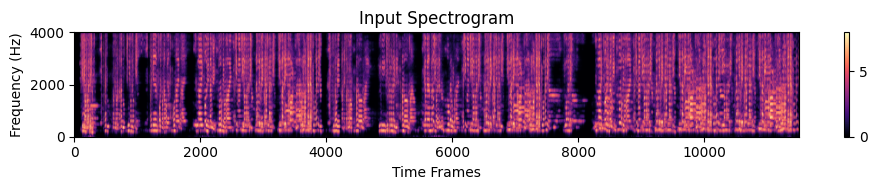

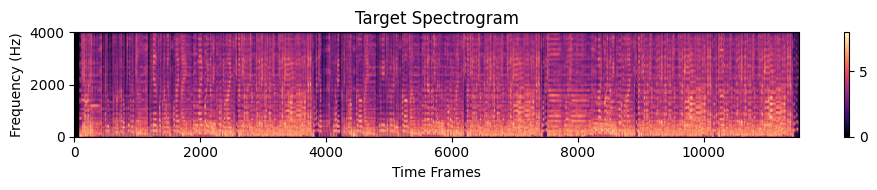

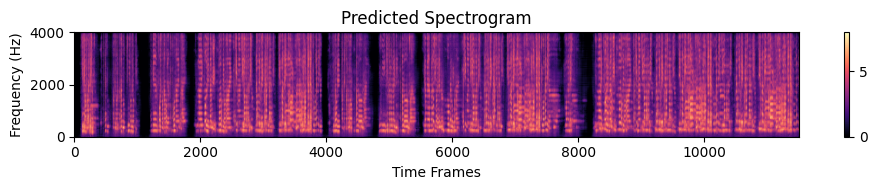

In [5]:
import torch
import numpy as np
import librosa
import musdb
import matplotlib.pyplot as plt
from IPython.display import Audio
from RESU.model import SpectrogramEnhancer
from UNET.model import UNetVocalSeparator 
import soundfile as sf 
from create_file_unet import create_npz

# PAThs
mus = musdb.DB(root="UNET/musdb18", subsets="test")  
track = mus.tracks[0] 

# Save the first track's mixture temporarily
 # Temporary WAV file
input_mix_path = "temp_mix.wav" 
# Output NPZ file
save_npz_path = "output_folder/temp_mix_output.npz"  

# Save the mono mixture
mix_audio = librosa.to_mono(track.audio.T) 
# Save at original MUSDB sample rate (44100 Hz)
sf.write(input_mix_path, mix_audio, track.rate)  

create_npz(input_mix_path, save_npz_path)


checkpoint_path = "RESU/enhancer_epoch300.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SpectrogramEnhancer().to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

def run_autoencoder_inference_with_plot(model, file_path, device=device):
    data = np.load(file_path)
    input_spec = data["input"][:512, :]
    target_spec = data["target"][:512, :]
    phase = data["phase"][:512, :]
    scale = data["scale"]

    input_mag = input_spec * scale
    target_mag = target_spec * scale

    input_log = np.log1p(input_mag)
    input_tensor = torch.tensor(input_log).unsqueeze(0).unsqueeze(0).to(device).float()

    model.eval()
    with torch.no_grad():
        recon_log = model(input_tensor).squeeze().cpu().numpy()

    recon_log = np.maximum(recon_log, 0.0)
    recon_mag = np.expm1(recon_log)

    recon_mag_full = np.pad(recon_mag, ((0, 1), (0, 0)), mode='constant')
    phase_full = np.pad(phase, ((0, 1), (0, 0)), mode='constant')

    complex_spec_pred = recon_mag_full * np.exp(1j * phase_full)
    waveform_pred = librosa.istft(complex_spec_pred, hop_length=768, win_length=1024)

    input_mag_full = np.pad(input_mag, ((0, 1), (0, 0)), mode='constant')
    complex_spec_input = input_mag_full * np.exp(1j * phase_full)
    waveform_input = librosa.istft(complex_spec_input, hop_length=768, win_length=1024)

    # Plot
    def plot_spectrogram(specgram, title="", sr=44100, n_fft=1024, freq_limit=4000, vmax=8):
        freqs = np.linspace(0, sr / 2, n_fft // 2 + 1)[:specgram.shape[0]]
        fig, ax = plt.subplots(figsize=(10, 2))
        img = ax.imshow(np.log1p(specgram), aspect='auto', origin='lower',
                        extent=[0, specgram.shape[1], freqs[0], freqs[-1]],
                        cmap='magma', vmax=vmax)
        fig.colorbar(img, ax=ax)
        ax.set_xlabel("Time Frames")
        ax.set_ylabel("Frequency (Hz)")
        ax.set_title(title)
        ax.set_ylim(0, freq_limit)
        plt.tight_layout()
        plt.show()

    plot_spectrogram(input_mag, title="Input Spectrogram")
    plot_spectrogram(target_mag, title="Target Spectrogram")
    plot_spectrogram(recon_mag, title="Predicted Spectrogram")

    return Audio(waveform_pred, rate=44100), Audio(waveform_input, rate=44100), recon_mag, target_mag, waveform_pred

pred_audio, input_audio, recon_mag, target_mag, waveform_pred = run_autoencoder_inference_with_plot(
    model, save_npz_path)

# display(pred_audio)
# display(input_audio)


In [4]:
import museval
import numpy as np

min_T = min(recon_mag.shape[1], target_mag.shape[1])
recon_mag_eval = recon_mag[:, :min_T]
target_mag_eval = target_mag[:, :min_T]

mse = np.mean((recon_mag_eval - target_mag_eval) ** 2)
mae = np.mean(np.abs(recon_mag_eval - target_mag_eval))

num = np.linalg.norm(target_mag_eval - recon_mag_eval, ord="fro")
den = np.linalg.norm(target_mag_eval, ord="fro")
spectral_convergence = num / (den + 1e-8)

log_diff = np.log10(target_mag_eval + 1e-8) - np.log10(recon_mag_eval + 1e-8)
lsd = np.sqrt(np.mean(log_diff**2))


print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"Spectral Convergence: {spectral_convergence:.6f}")
print(f"Log-Spectral Distance (LSD): {lsd:.6f}")


MSE: 5269.339844
MAE: 14.210833
Spectral Convergence: 0.789355
Log-Spectral Distance (LSD): 3.297951


# TEST CASE STUDY

✅ Saved NPZ for VAE: output_folder/temp_case_mix_output.npz


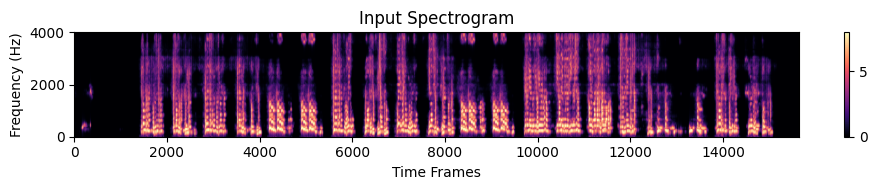

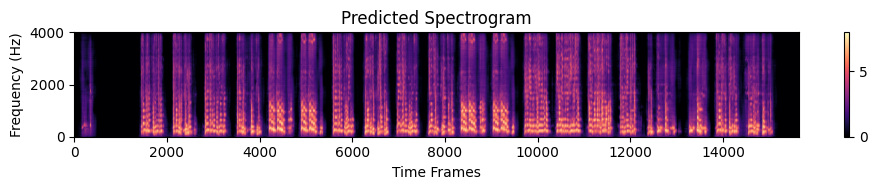

In [6]:
import torch
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from RESU.model import SpectrogramEnhancer
from UNET.model import UNetVocalSeparator 
import soundfile as sf 
from create_file_unet import create_npz
import soundfile as sf
import os

input_mix_path = "Tiptoe_-_Rivers_and_Leafs.mp3" 
save_npz_path = "output_folder/temp_case_mix_output.npz" 
create_npz(input_mix_path, save_npz_path)


checkpoint_path = "RESU/enhancer_epoch300.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SpectrogramEnhancer().to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()


def run_autoencoder_inference_with_plot(model, file_path, device=device):
    data = np.load(file_path)
    input_spec = data["input"][:512, :]
    target_spec = data["target"][:512, :]
    phase = data["phase"][:512, :]
    scale = data["scale"]

    input_mag = input_spec * scale
    target_mag = target_spec * scale

    input_log = np.log1p(input_mag)
    input_tensor = torch.tensor(input_log).unsqueeze(0).unsqueeze(0).to(device).float()

    model.eval()
    with torch.no_grad():
        recon_log = model(input_tensor).squeeze().cpu().numpy()

    recon_log = np.maximum(recon_log, 0.0)
    recon_mag = np.expm1(recon_log)

    recon_mag_full = np.pad(recon_mag, ((0, 1), (0, 0)), mode='constant')
    phase_full = np.pad(phase, ((0, 1), (0, 0)), mode='constant')

    complex_spec_pred = recon_mag_full * np.exp(1j * phase_full)
    waveform_pred = librosa.istft(complex_spec_pred, hop_length=768, win_length=1024)

    input_mag_full = np.pad(input_mag, ((0, 1), (0, 0)), mode='constant')
    complex_spec_input = input_mag_full * np.exp(1j * phase_full)
    waveform_input = librosa.istft(complex_spec_input, hop_length=768, win_length=1024)

    def plot_spectrogram(specgram, title="", sr=44100, n_fft=1024, freq_limit=4000, vmax=8):
        freqs = np.linspace(0, sr / 2, n_fft // 2 + 1)[:specgram.shape[0]]
        fig, ax = plt.subplots(figsize=(10, 2))
        img = ax.imshow(np.log1p(specgram), aspect='auto', origin='lower',
                        extent=[0, specgram.shape[1], freqs[0], freqs[-1]],
                        cmap='magma', vmax=vmax)
        fig.colorbar(img, ax=ax)
        ax.set_xlabel("Time Frames")
        ax.set_ylabel("Frequency (Hz)")
        ax.set_title(title)
        ax.set_ylim(0, freq_limit)
        plt.tight_layout()
        plt.show()

    plot_spectrogram(input_mag, title="Input Spectrogram")
    plot_spectrogram(recon_mag, title="Predicted Spectrogram")

    return Audio(waveform_pred, rate=44100), Audio(waveform_input, rate=44100), recon_mag, waveform_pred

pred_audio, input_audio, recon_mag, waveform_pred = run_autoencoder_inference_with_plot(
    model, save_npz_path)

# display(pred_audio)
# display(input_audio)